# Import dependencies

In [1]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [2]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

            Date Country  Province  Infected  Deaths  Recovered
13845 2020-04-10      US   Wyoming       239       0          0
13846 2020-04-10   China  Xinjiang         0       3         73
13847 2020-04-10  Canada     Yukon         8       0          0
13848 2020-04-10   China    Yunnan         9       2        173
13849 2020-04-10   China  Zhejiang        31       1       1235
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       13850 non-null  datetime64[ns]
 1   Country    13850 non-null  object        
 2   Province   13850 non-null  object        
 3   Infected   13850 non-null  int64         
 4   Deaths     13850 non-null  int64         
 5   Recovered  13850 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 649.3+ KB
None


'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

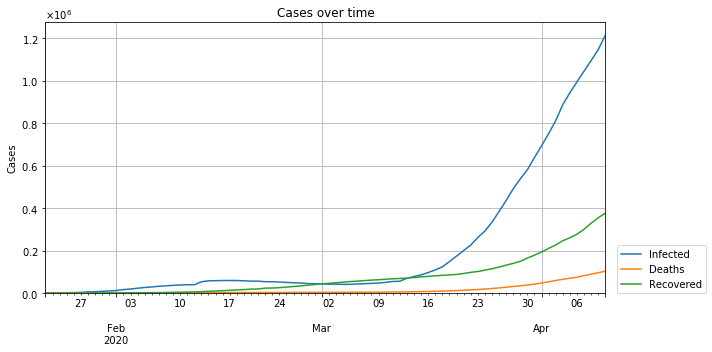

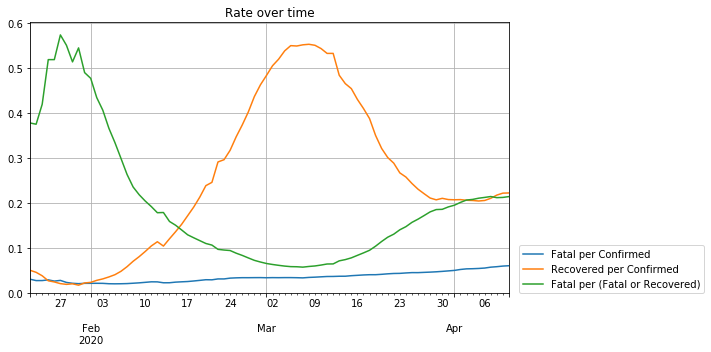

In [3]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

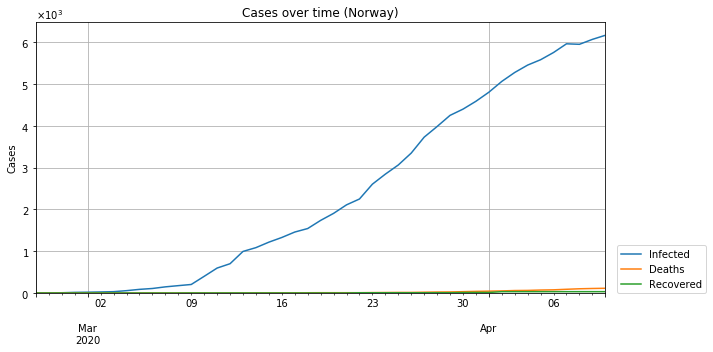

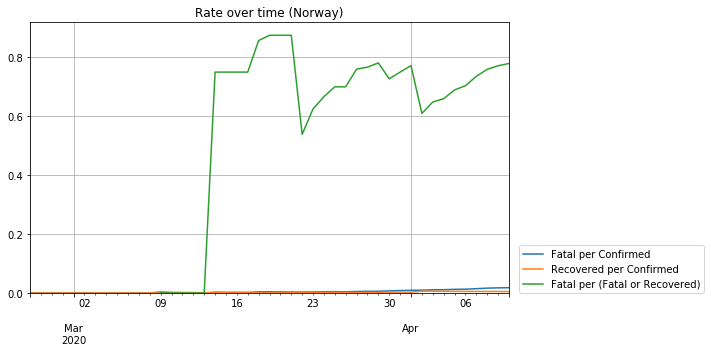

In [4]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [5]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

/Users/adil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

## The SIR epidemic model

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

 * $S(t)$: Susceptible       (= All - Confirmed)
 * $I(t)$: Infected          (= Confirmed - Recovered - Deaths)
 * $R(t)$: Recovered or Died (= Recovered + Deaths)
 
 

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 

* $\beta$ describes the effective contact rate of the disease: an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$). 

* $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:


$$\frac{dS}{dT}=\frac{-\beta}{N}SI$$

$$\frac{dI}{dT}=\frac{\beta SI}{N}-\gamma I$$

$$\frac{dR}{dT}=\gamma I$$

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

<a href="https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/">Sample code</a>


## Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$$\frac{dx}{dt}= - \rho x y$$  
$$\frac{dy}{dt}= \rho x y - \sigma y$$  
$$\frac{dz}{dt}= \sigma y$$

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

In [6]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 113760]


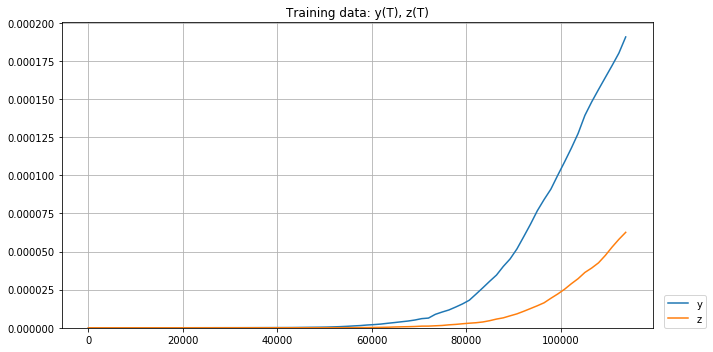

In [7]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [8]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [9]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 6.09 ms, sys: 1.14 ms, total: 7.22 ms
Wall time: 6.07 ms


,t,x,y,z
296,296,0.108567,0.000636,0.890797
297,297,0.108554,0.000600,0.890846
298,298,0.108541,0.000566,0.890893
299,299,0.108529,0.000534,0.890937
300,300,0.108518,0.000504,0.890978


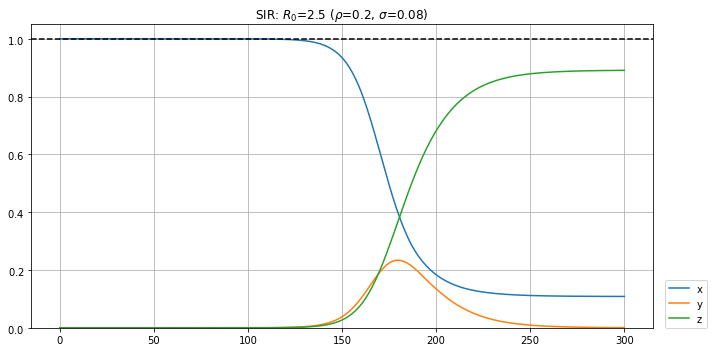

In [10]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [11]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-04-11 09:19:38,600] Finished trial#2 resulted in value: 11294108304.258104. Current best value is 11294108304.258104 with parameters: {'tau': 1338, 'rho': 0.1229148868786932, 'sigma': 0.015258461248217113}.
[I 2020-04-11 09:19:38,655] Finished trial#5 resulted in value: 13886452658.59914. Current best value is 11294108304.258104 with parameters: {'tau': 1338, 'rho': 0.1229148868786932, 'sigma': 0.015258461248217113}.
[I 2020-04-11 09:19:38,714] Finished trial#10 resulted in value: 11129235183.125126. Current best value is 11129235183.125126 with parameters: {'tau': 379, 'rho': 0.03225224881964926, 'sigma': 0.0036572717574122606}.
[I 2020-04-11 09:19:38,901] Finished trial#11 resulted in value: 11891437628.32948. Current best value is 11129235183.125126 with parameters: {'tau': 379, 'rho': 0.03225224881964926, 'sigma': 0.0036572717574122606}.
[I 2020-04-11 09:19:38,901] Finished trial#6 resulted in value: 11012604616.842142. Current best value is 11012604616.842142 with paramete

[I 2020-04-11 09:19:41,252] Finished trial#35 resulted in value: 10509010093.59136. Current best value is 10381838596.824306 with parameters: {'tau': 1199, 'rho': 0.11538306330328954, 'sigma': 0.01229883615564511}.
[I 2020-04-11 09:19:41,369] Finished trial#37 resulted in value: 12126389701.982965. Current best value is 10381838596.824306 with parameters: {'tau': 1199, 'rho': 0.11538306330328954, 'sigma': 0.01229883615564511}.
[I 2020-04-11 09:19:41,448] Finished trial#41 resulted in value: 10947185073.24228. Current best value is 10381838596.824306 with parameters: {'tau': 1199, 'rho': 0.11538306330328954, 'sigma': 0.01229883615564511}.
[I 2020-04-11 09:19:41,527] Finished trial#42 resulted in value: 10684061277.591192. Current best value is 10381838596.824306 with parameters: {'tau': 1199, 'rho': 0.11538306330328954, 'sigma': 0.01229883615564511}.
[I 2020-04-11 09:19:41,604] Finished trial#39 resulted in value: 23236384174.11947. Current best value is 10381838596.824306 with paramete

[I 2020-04-11 09:19:44,164] Finished trial#72 resulted in value: 10279697013.138142. Current best value is 10135190957.474052 with parameters: {'tau': 1367, 'rho': 0.14414246343519202, 'sigma': 0.023923699764720925}.
[I 2020-04-11 09:19:44,298] Finished trial#73 resulted in value: 10605062601.93777. Current best value is 10135190957.474052 with parameters: {'tau': 1367, 'rho': 0.14414246343519202, 'sigma': 0.023923699764720925}.
[I 2020-04-11 09:19:44,299] Finished trial#70 resulted in value: 10570332916.093008. Current best value is 10135190957.474052 with parameters: {'tau': 1367, 'rho': 0.14414246343519202, 'sigma': 0.023923699764720925}.
[I 2020-04-11 09:19:44,383] Finished trial#74 resulted in value: 12126207976.488781. Current best value is 10135190957.474052 with parameters: {'tau': 1367, 'rho': 0.14414246343519202, 'sigma': 0.023923699764720925}.
[I 2020-04-11 09:19:44,478] Finished trial#77 resulted in value: 11190877919.030718. Current best value is 10135190957.474052 with pa

[I 2020-04-11 09:19:47,243] Finished trial#112 resulted in value: 10117553579.920881. Current best value is 10059585091.38062 with parameters: {'tau': 1390, 'rho': 0.14534679119346322, 'sigma': 0.019744738174134763}.
[I 2020-04-11 09:19:47,312] Finished trial#113 resulted in value: 10194932887.227123. Current best value is 10059585091.38062 with parameters: {'tau': 1390, 'rho': 0.14534679119346322, 'sigma': 0.019744738174134763}.
[I 2020-04-11 09:19:47,379] Finished trial#114 resulted in value: 10051912123.813108. Current best value is 10051912123.813108 with parameters: {'tau': 1440, 'rho': 0.14793114185325512, 'sigma': 0.02011376017124432}.
[I 2020-04-11 09:19:47,455] Finished trial#115 resulted in value: 10357038839.96853. Current best value is 10051912123.813108 with parameters: {'tau': 1440, 'rho': 0.14793114185325512, 'sigma': 0.02011376017124432}.
[I 2020-04-11 09:19:47,603] Finished trial#120 resulted in value: 10086766267.221619. Current best value is 10051912123.813108 with p

[I 2020-04-11 09:19:51,045] Finished trial#147 resulted in value: 10059380775.420593. Current best value is 9997900545.227468 with parameters: {'tau': 1436, 'rho': 0.14962408891097195, 'sigma': 0.02050819448661806}.
[I 2020-04-11 09:19:51,116] Finished trial#148 resulted in value: 10020314362.550606. Current best value is 9997900545.227468 with parameters: {'tau': 1436, 'rho': 0.14962408891097195, 'sigma': 0.02050819448661806}.
[I 2020-04-11 09:19:51,228] Finished trial#149 resulted in value: 10057575151.123262. Current best value is 9997900545.227468 with parameters: {'tau': 1436, 'rho': 0.14962408891097195, 'sigma': 0.02050819448661806}.
[I 2020-04-11 09:19:51,316] Finished trial#150 resulted in value: 10070729324.540213. Current best value is 9997900545.227468 with parameters: {'tau': 1436, 'rho': 0.14962408891097195, 'sigma': 0.02050819448661806}.
[I 2020-04-11 09:19:51,399] Finished trial#151 resulted in value: 10038061031.20682. Current best value is 9997900545.227468 with parame

[I 2020-04-11 09:19:54,588] Finished trial#189 resulted in value: 10321313914.384031. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:54,731] Finished trial#190 resulted in value: 10057378579.251383. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:54,816] Finished trial#191 resulted in value: 10698557934.045725. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:54,958] Finished trial#192 resulted in value: 10028149727.632313. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:55,044] Finished trial#193 resulted in value: 10012230627.84442. Current best value is 9996147656.835981 with parameters

[I 2020-04-11 09:19:58,641] Finished trial#221 resulted in value: 13134447158.58822. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:58,736] Finished trial#152 resulted in value: 11665930969.55854. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:58,840] Finished trial#223 resulted in value: 10004116753.410881. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:58,920] Finished trial#222 resulted in value: 10068852893.454454. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:19:59,016] Finished trial#224 resulted in value: 10380472069.495144. Current best value is 9996147656.835981 with parameters:

[I 2020-04-11 09:20:02,279] Finished trial#253 resulted in value: 13268340370.192862. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:20:02,395] Finished trial#256 resulted in value: 10010988414.13024. Current best value is 9996147656.835981 with parameters: {'tau': 1439, 'rho': 0.1496946440355816, 'sigma': 0.02043071780750698}.
[I 2020-04-11 09:20:02,489] Finished trial#254 resulted in value: 9993518041.263205. Current best value is 9993518041.263205 with parameters: {'tau': 1439, 'rho': 0.14951086621056017, 'sigma': 0.02008028260477669}.
[I 2020-04-11 09:20:02,572] Finished trial#255 resulted in value: 10012601441.34764. Current best value is 9993518041.263205 with parameters: {'tau': 1439, 'rho': 0.14951086621056017, 'sigma': 0.02008028260477669}.
[I 2020-04-11 09:20:02,662] Finished trial#257 resulted in value: 9991342469.961008. Current best value is 9991342469.961008 with parameters:

[I 2020-04-11 09:20:05,946] Finished trial#288 resulted in value: 10022390397.692345. Current best value is 9990468172.671068 with parameters: {'tau': 1437, 'rho': 0.14949252072240793, 'sigma': 0.0195560771652491}.
[I 2020-04-11 09:20:06,066] Finished trial#287 resulted in value: 10312919331.825214. Current best value is 9990468172.671068 with parameters: {'tau': 1437, 'rho': 0.14949252072240793, 'sigma': 0.0195560771652491}.
[I 2020-04-11 09:20:06,183] Finished trial#289 resulted in value: 10015854601.35549. Current best value is 9990468172.671068 with parameters: {'tau': 1437, 'rho': 0.14949252072240793, 'sigma': 0.0195560771652491}.
[I 2020-04-11 09:20:06,271] Finished trial#291 resulted in value: 10015895984.820955. Current best value is 9990468172.671068 with parameters: {'tau': 1437, 'rho': 0.14949252072240793, 'sigma': 0.0195560771652491}.
[I 2020-04-11 09:20:06,391] Finished trial#290 resulted in value: 10016087833.59397. Current best value is 9990468172.671068 with parameters:

[I 2020-04-11 09:20:09,762] Finished trial#326 resulted in value: 10181833500.71285. Current best value is 9987657203.129805 with parameters: {'tau': 1440, 'rho': 0.14926429812476724, 'sigma': 0.019249621286191534}.
[I 2020-04-11 09:20:09,945] Finished trial#328 resulted in value: 10128173838.432413. Current best value is 9987657203.129805 with parameters: {'tau': 1440, 'rho': 0.14926429812476724, 'sigma': 0.019249621286191534}.
[I 2020-04-11 09:20:10,086] Finished trial#330 resulted in value: 10119741279.683033. Current best value is 9987657203.129805 with parameters: {'tau': 1440, 'rho': 0.14926429812476724, 'sigma': 0.019249621286191534}.
[I 2020-04-11 09:20:10,179] Finished trial#329 resulted in value: 11270791782.989561. Current best value is 9987657203.129805 with parameters: {'tau': 1440, 'rho': 0.14926429812476724, 'sigma': 0.019249621286191534}.
[I 2020-04-11 09:20:10,284] Finished trial#331 resulted in value: 10498007514.019442. Current best value is 9987657203.129805 with pa

[I 2020-04-11 09:20:13,956] Finished trial#366 resulted in value: 10544155861.86847. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:14,062] Finished trial#367 resulted in value: 10037592018.361094. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:14,189] Finished trial#368 resulted in value: 10448059739.588459. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:14,327] Finished trial#369 resulted in value: 10033205948.919155. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:14,458] Finished trial#370 resulted in value: 10060607184.03442. Current best value is 9986497051.192804 with par

[I 2020-04-11 09:20:18,376] Finished trial#404 resulted in value: 9992667451.799265. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:18,482] Finished trial#359 resulted in value: 14570526646.444239. Current best value is 9986497051.192804 with parameters: {'tau': 1440, 'rho': 0.14914906153832938, 'sigma': 0.018717878613450672}.
[I 2020-04-11 09:20:18,580] Finished trial#406 resulted in value: 9983585555.267546. Current best value is 9983585555.267546 with parameters: {'tau': 1440, 'rho': 0.14888535683141116, 'sigma': 0.018558575878963174}.
[I 2020-04-11 09:20:18,695] Finished trial#405 resulted in value: 9993060119.875902. Current best value is 9983585555.267546 with parameters: {'tau': 1440, 'rho': 0.14888535683141116, 'sigma': 0.018558575878963174}.
[I 2020-04-11 09:20:18,866] Finished trial#407 resulted in value: 10264145771.505064. Current best value is 9983585555.267546 with para

[I 2020-04-11 09:20:23,407] Finished trial#441 resulted in value: 9985694364.272097. Current best value is 9982373757.06927 with parameters: {'tau': 1439, 'rho': 0.1487092485872112, 'sigma': 0.017696981083199892}.
[I 2020-04-11 09:20:23,505] Finished trial#399 resulted in value: 11363420160.357859. Current best value is 9982373757.06927 with parameters: {'tau': 1439, 'rho': 0.1487092485872112, 'sigma': 0.017696981083199892}.
[I 2020-04-11 09:20:23,605] Finished trial#442 resulted in value: 13586181321.664003. Current best value is 9982373757.06927 with parameters: {'tau': 1439, 'rho': 0.1487092485872112, 'sigma': 0.017696981083199892}.
[I 2020-04-11 09:20:23,795] Finished trial#443 resulted in value: 10488656127.397089. Current best value is 9982373757.06927 with parameters: {'tau': 1439, 'rho': 0.1487092485872112, 'sigma': 0.017696981083199892}.
[I 2020-04-11 09:20:23,893] Finished trial#444 resulted in value: 13172929479.141338. Current best value is 9982373757.06927 with parameters:

[I 2020-04-11 09:20:27,887] Finished trial#474 resulted in value: 12220143671.7714. Current best value is 9982097877.090282 with parameters: {'tau': 1440, 'rho': 0.14838067674079808, 'sigma': 0.017345621676531375}.
[I 2020-04-11 09:20:27,986] Finished trial#475 resulted in value: 9986439014.037804. Current best value is 9982097877.090282 with parameters: {'tau': 1440, 'rho': 0.14838067674079808, 'sigma': 0.017345621676531375}.
[I 2020-04-11 09:20:28,121] Finished trial#476 resulted in value: 10046733734.49793. Current best value is 9982097877.090282 with parameters: {'tau': 1440, 'rho': 0.14838067674079808, 'sigma': 0.017345621676531375}.
[I 2020-04-11 09:20:28,297] Finished trial#413 resulted in value: 11201254248.325684. Current best value is 9982097877.090282 with parameters: {'tau': 1440, 'rho': 0.14838067674079808, 'sigma': 0.017345621676531375}.
[I 2020-04-11 09:20:28,397] Finished trial#477 resulted in value: 10018866795.397963. Current best value is 9982097877.090282 with param

CPU times: user 54.6 s, sys: 4.58 s, total: 59.2 s
Wall time: 53.6 s


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



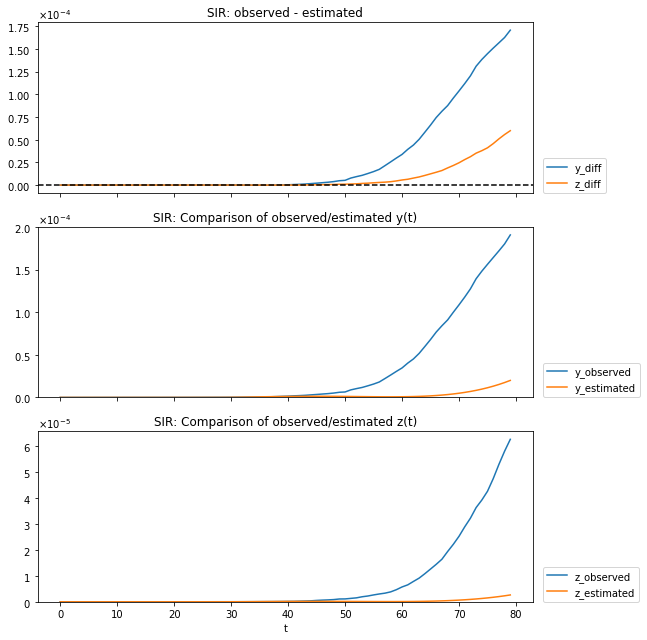

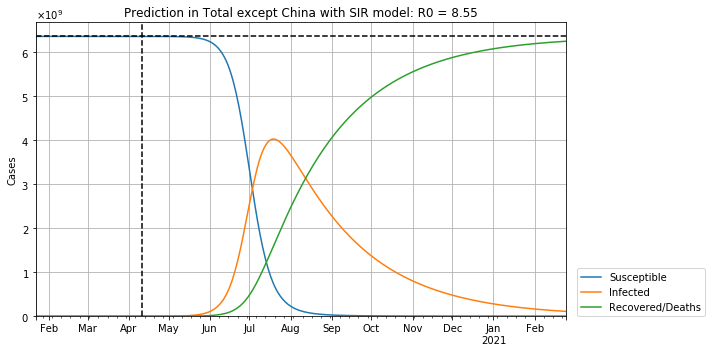

In [12]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [13]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-04-11 09:20:33,570] Finished trial#3 resulted in value: 127709035949.24815. Current best value is 127709035949.24815 with parameters: {'tau': 761, 'kappa': 0.003115376617451548, 'rho': 0.06405427948949115, 'sigma': 0.007038092892161559}.
[I 2020-04-11 09:20:33,571] Finished trial#0 resulted in value: 128665721684.21034. Current best value is 127709035949.24815 with parameters: {'tau': 761, 'kappa': 0.003115376617451548, 'rho': 0.06405427948949115, 'sigma': 0.007038092892161559}.
[I 2020-04-11 09:20:33,684] Finished trial#5 resulted in value: 119015882291.3247. Current best value is 119015882291.3247 with parameters: {'tau': 1104, 'kappa': 0.004946527906987432, 'rho': 0.1143826007158183, 'sigma': 0.014407566483422025}.
[I 2020-04-11 09:20:33,810] Finished trial#4 resulted in value: 306209293386.9972. Current best value is 119015882291.3247 with parameters: {'tau': 1104, 'kappa': 0.004946527906987432, 'rho': 0.1143826007158183, 'sigma': 0.014407566483422025}.
[I 2020-04-11 09:20:

[I 2020-04-11 09:20:35,996] Finished trial#34 resulted in value: 116305012655.99081. Current best value is 111976683763.8172 with parameters: {'tau': 1361, 'kappa': 0.005070866349734935, 'rho': 0.14424679750336583, 'sigma': 0.01871117609667511}.
[I 2020-04-11 09:20:36,066] Finished trial#33 resulted in value: 125218981408.66495. Current best value is 111976683763.8172 with parameters: {'tau': 1361, 'kappa': 0.005070866349734935, 'rho': 0.14424679750336583, 'sigma': 0.01871117609667511}.
[I 2020-04-11 09:20:36,141] Finished trial#37 resulted in value: 124774041056.40912. Current best value is 111976683763.8172 with parameters: {'tau': 1361, 'kappa': 0.005070866349734935, 'rho': 0.14424679750336583, 'sigma': 0.01871117609667511}.
[I 2020-04-11 09:20:36,217] Finished trial#35 resulted in value: 121694719750.05965. Current best value is 111976683763.8172 with parameters: {'tau': 1361, 'kappa': 0.005070866349734935, 'rho': 0.14424679750336583, 'sigma': 0.01871117609667511}.
[I 2020-04-11 09

[I 2020-04-11 09:20:39,285] Finished trial#51 resulted in value: 240195906654.0407. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:39,429] Finished trial#75 resulted in value: 194252356810.70544. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:39,502] Finished trial#58 resulted in value: 122417731298.7497. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:39,573] Finished trial#76 resulted in value: 137590902563.23022. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04

[I 2020-04-11 09:20:42,692] Finished trial#105 resulted in value: 111466760029.754. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:42,786] Finished trial#80 resulted in value: 196131303004.99817. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:42,862] Finished trial#86 resulted in value: 119413613327.24199. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:42,937] Finished trial#106 resulted in value: 110143878822.74414. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-

[I 2020-04-11 09:20:45,765] Finished trial#132 resulted in value: 130692430610.16147. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:45,879] Finished trial#131 resulted in value: 137680489747.864. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:46,038] Finished trial#134 resulted in value: 179768665646.87122. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:46,038] Finished trial#89 resulted in value: 122740502895.04698. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020

[I 2020-04-11 09:20:48,882] Finished trial#160 resulted in value: 110564694020.2569. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:48,997] Finished trial#162 resulted in value: 109967847421.80971. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:49,080] Finished trial#163 resulted in value: 110615128823.76535. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:49,230] Finished trial#165 resulted in value: 109735852239.05775. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 20

[I 2020-04-11 09:20:52,165] Finished trial#196 resulted in value: 109709967788.19327. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:52,261] Finished trial#197 resulted in value: 109847377191.85841. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:52,397] Finished trial#199 resulted in value: 110206279519.13498. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:52,476] Finished trial#198 resulted in value: 109830925567.88454. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2

[I 2020-04-11 09:20:56,390] Finished trial#225 resulted in value: 222356409365.2616. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:56,480] Finished trial#233 resulted in value: 109129990255.97124. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:56,570] Finished trial#234 resulted in value: 112836555214.98546. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 2020-04-11 09:20:56,755] Finished trial#235 resulted in value: 113404757756.6457. Current best value is 108989527662.04182 with parameters: {'tau': 1426, 'kappa': 0.0037652687822187585, 'rho': 0.15477289012605738, 'sigma': 0.01982059394246023}.
[I 202

[I 2020-04-11 09:21:00,134] Finished trial#262 resulted in value: 112927646567.06923. Current best value is 108902562289.74762 with parameters: {'tau': 1438, 'kappa': 0.0035396186068078882, 'rho': 0.15476548468459694, 'sigma': 0.01984609541881085}.
[I 2020-04-11 09:21:00,135] Finished trial#261 resulted in value: 113246491170.85457. Current best value is 108902562289.74762 with parameters: {'tau': 1438, 'kappa': 0.0035396186068078882, 'rho': 0.15476548468459694, 'sigma': 0.01984609541881085}.
[I 2020-04-11 09:21:00,287] Finished trial#263 resulted in value: 108977499269.20116. Current best value is 108902562289.74762 with parameters: {'tau': 1438, 'kappa': 0.0035396186068078882, 'rho': 0.15476548468459694, 'sigma': 0.01984609541881085}.
[I 2020-04-11 09:21:00,372] Finished trial#264 resulted in value: 108858370133.76036. Current best value is 108858370133.76036 with parameters: {'tau': 1415, 'kappa': 0.0034298752872800645, 'rho': 0.15267346782538968, 'sigma': 0.019564830754864038}.
[I 

[I 2020-04-11 09:21:03,646] Finished trial#294 resulted in value: 108826272678.44867. Current best value is 108791221735.93889 with parameters: {'tau': 1440, 'kappa': 0.0034876859730887705, 'rho': 0.15295264501840583, 'sigma': 0.018645938301712336}.
[I 2020-04-11 09:21:03,739] Finished trial#293 resulted in value: 108888935565.72841. Current best value is 108791221735.93889 with parameters: {'tau': 1440, 'kappa': 0.0034876859730887705, 'rho': 0.15295264501840583, 'sigma': 0.018645938301712336}.
[I 2020-04-11 09:21:03,828] Finished trial#295 resulted in value: 109085888911.48584. Current best value is 108791221735.93889 with parameters: {'tau': 1440, 'kappa': 0.0034876859730887705, 'rho': 0.15295264501840583, 'sigma': 0.018645938301712336}.
[I 2020-04-11 09:21:03,962] Finished trial#296 resulted in value: 109095789472.7326. Current best value is 108791221735.93889 with parameters: {'tau': 1440, 'kappa': 0.0034876859730887705, 'rho': 0.15295264501840583, 'sigma': 0.018645938301712336}.
[

[I 2020-04-11 09:21:07,477] Finished trial#325 resulted in value: 110773771687.29434. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:07,572] Finished trial#326 resulted in value: 110459440320.10255. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:07,664] Finished trial#327 resulted in value: 111064638965.58516. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:07,867] Finished trial#329 resulted in value: 109846882433.43262. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.


[I 2020-04-11 09:21:11,706] Finished trial#361 resulted in value: 123098205198.6404. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:11,902] Finished trial#362 resulted in value: 139614693926.85382. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:11,992] Finished trial#363 resulted in value: 108702684097.3859. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:12,114] Finished trial#364 resulted in value: 175589089503.7927. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 

[I 2020-04-11 09:21:16,627] Finished trial#286 resulted in value: 125430794992.87402. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:16,742] Finished trial#288 resulted in value: 390325446275.3043. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:16,941] Finished trial#395 resulted in value: 108748211936.55167. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I 2020-04-11 09:21:17,041] Finished trial#396 resulted in value: 109348001329.1483. Current best value is 108664450506.82661 with parameters: {'tau': 1437, 'kappa': 0.0027097884670737446, 'rho': 0.15174037466099682, 'sigma': 0.018490867697748208}.
[I

[I 2020-04-11 09:21:21,236] Finished trial#424 resulted in value: 109100485345.91191. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:21,410] Finished trial#331 resulted in value: 252641620984.5235. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:21,516] Finished trial#425 resulted in value: 109649013897.87288. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:21,620] Finished trial#426 resulted in value: 118540307857.60538. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 20

[I 2020-04-11 09:21:25,465] Finished trial#452 resulted in value: 135141354986.08768. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:25,625] Finished trial#453 resulted in value: 122432664121.70348. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:25,769] Finished trial#454 resulted in value: 129497659288.82486. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2020-04-11 09:21:25,874] Finished trial#455 resulted in value: 108786014065.84099. Current best value is 108562598466.1262 with parameters: {'tau': 1440, 'kappa': 0.0022581342088582863, 'rho': 0.15090107306357703, 'sigma': 0.016361837429398375}.
[I 2

[I 2020-04-11 09:21:30,077] Finished trial#490 resulted in value: 108609473988.02167. Current best value is 108502459920.7262 with parameters: {'tau': 1440, 'kappa': 0.0027806942581906947, 'rho': 0.14978180076583555, 'sigma': 0.015586688796545779}.
[I 2020-04-11 09:21:30,373] Finished trial#474 resulted in value: 178624771019.51846. Current best value is 108502459920.7262 with parameters: {'tau': 1440, 'kappa': 0.0027806942581906947, 'rho': 0.14978180076583555, 'sigma': 0.015586688796545779}.
[I 2020-04-11 09:21:30,557] Finished trial#493 resulted in value: 108744160322.96999. Current best value is 108502459920.7262 with parameters: {'tau': 1440, 'kappa': 0.0027806942581906947, 'rho': 0.14978180076583555, 'sigma': 0.015586688796545779}.
[I 2020-04-11 09:21:30,749] Finished trial#494 resulted in value: 110622720869.15294. Current best value is 108502459920.7262 with parameters: {'tau': 1440, 'kappa': 0.0027806942581906947, 'rho': 0.14978180076583555, 'sigma': 0.015586688796545779}.
[I 2

CPU times: user 1min, sys: 5.82 s, total: 1min 6s
Wall time: 60 s


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



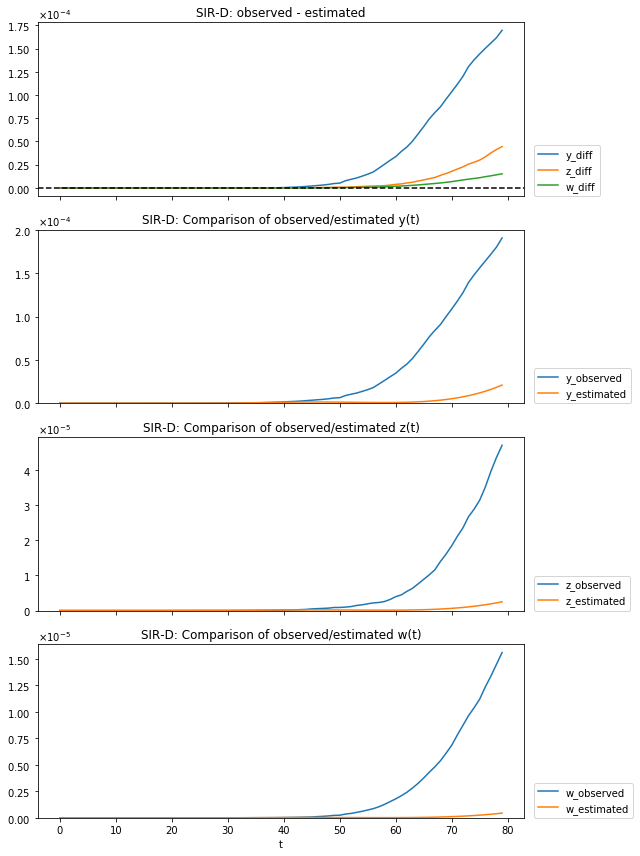

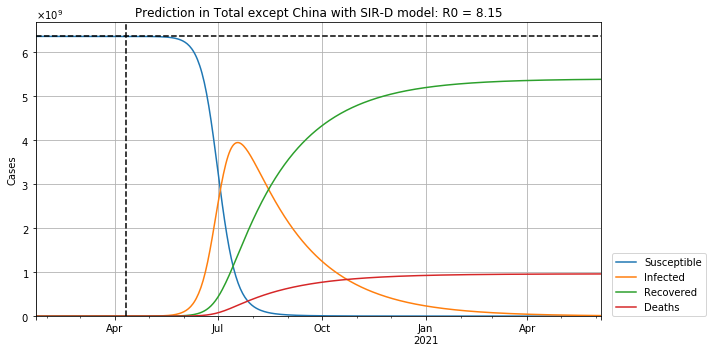

In [14]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

# References

Further Reading

* M. J. Keeling and P. Rohani, <a href="http://press.princeton.edu/titles/8459.html">Modeling Infectious Diseases in Humans and Animals</a>, Princeton (2007).
* R. M. Anderson and R. M. May, <a href="http://www.amazon.co.uk/Infectious-Diseases-Humans-Dynamics-Publications/dp/019854040X">Infectious Diseases of Humans: Dynamics and Control,</a> OUP (1992).